In [7]:
import math
import os
import importlib
import time
import pathlib

import numpy as np
import pandas as pd

import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
import skimage
from skimage import transform as skimg_transform
#from skimage import io as img_io
from PIL import Image

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import transforms, utils, models
from torch.utils import data
from torch.utils.data.sampler import SubsetRandomSampler

import load_data
#import model
import warnings

In [40]:
plt.style.use('Solarize_Light2')
warnings.filterwarnings('ignore')
%matplotlib inline
importlib.reload(load_data)
#importlib.reload(model)

<module 'load_data' from '/home/uldo/work/kaggle/competitions/Severstal-Steel-Defect-Detection/code/load_data.py'>

In [5]:
train_images_dir = '../input/train/'
test_images_dir = '../input/test'

In [9]:
train_df = pd.read_csv('../input/train.csv')

In [10]:
image_descriptions_list = [row.split('_') for row in train_df['ImageId_ClassId']]

In [11]:
train_df['image_name'] = [image_name for image_name, _ in image_descriptions_list]
train_df['image_class'] = [image_class for _, image_class in image_descriptions_list]

In [12]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50272 entries, 0 to 50271
Data columns (total 4 columns):
ImageId_ClassId    50272 non-null object
EncodedPixels      7095 non-null object
image_name         50272 non-null object
image_class        50272 non-null object
dtypes: object(4)
memory usage: 1.5+ MB


In [13]:
# train_images_names = pathlib.Path().glob('../input/train/*')
# for img_name in tuple(train_images_names)[:10]:
#     print(img_name)

In [14]:
train_df.head()

,ImageId_ClassId,EncodedPixels,image_name,image_class
0,0002cc93b.jpg_1,29102 12 29346 24 29602 24 29858 24 30114 24 3...,0002cc93b.jpg,1
1,0002cc93b.jpg_2,NaN,0002cc93b.jpg,2
2,0002cc93b.jpg_3,NaN,0002cc93b.jpg,3
3,0002cc93b.jpg_4,NaN,0002cc93b.jpg,4
4,00031f466.jpg_1,NaN,00031f466.jpg,1


In [109]:
#BATCH_SIZE = 100
#BATCH_SIZE = 32
#BATCH_SIZE = 200
#BATCH_SIZE = 128
BATCH_SIZE = 64
#BATCH_SIZE = 32
#IMAGE_W = 100
#IMAGE_W = 256
#IMAGE_W = 64
#IMAGE_W = 128
IMAGE_W = 1600
#IMAGE_H = 100
#IMAGE_H = 256
#IMAGE_H = 64
#IMAGE_H = 128
IMAGE_H = 256

In [16]:
class ConvNeuralNet(nn.Module):
    
    def __init__(self):
        super(ConvNeuralNet, self).__init__()

        self.conv1 = nn.Conv2d(3, 32, kernel_size=9, stride=2, padding=4)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=5, stride=2, padding=2)
        self.fc1 = nn.Linear(32768 * 16, 1024)
        self.fc2 = nn.Linear(1024, 32)
        self.pool = torch.nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.sigmoid = nn.Sigmoid()
        self.dropout = nn.Dropout(0.5)
        

    def forward(self, x):
        
        x = F.relu(self.conv1(x))
        x = self.pool(x)
        x = F.relu(self.conv2(x))
        x = self.pool(x)     
        x = x.view(-1, 32768 * 16)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        x = self.sigmoid(x)
        return x     

In [17]:
class Rescale(object):
    """Rescale the image in a sample to a given size.

    Args:
        output_size (tuple or int): Desired output size. If tuple, output is
            matched to output_size. If int, smaller of image edges is matched
            to output_size keeping aspect ratio the same.
    """

    def __init__(self, output_size):
        assert isinstance(output_size, (int, tuple))
        self.output_size = output_size

    def __call__(self, sample):
        image, label = sample['image'], sample['label']

        orig_height, orig_width = image.shape[:2]
        if isinstance(self.output_size, int):
            if orig_height > orig_width:
                new_height, new_width = self.output_size * orig_height / orig_width, self.output_size
            else:
                new_height, new_width = self.output_size, self.output_size * orig_width / orig_height
        else:
            new_height, new_width = self.output_size

        new_height, new_width = int(new_height), int(new_width)

        img = skimg_transform.resize(image, (new_height, new_width))

        return {'image': img, 'label': label}

In [18]:
class UnifyRescale(object):
    
    def __init__(self, output_size=128):
        assert isinstance(output_size, int)
        self.output_size = output_size
        
    def __call__(self, sample):
        image, label = sample['image'], sample['label']

        img = skimg_transform.resize(image, (self.output_size, self.output_size))

        return {'image': img, 'label': label}

In [19]:
class RandomCrop(object):
    """Crop randomly the image in a sample.

    Args:
        output_size (tuple or int): Desired output size. If int, square crop
            is made.
    """

    def __init__(self, output_size):
        assert isinstance(output_size, (int, tuple))
        if isinstance(output_size, int):
            self.output_size = (output_size, output_size)
        else:
            assert len(output_size) == 2
            self.output_size = output_size

    def __call__(self, sample):
        image, label = sample['image'], sample['label']

        orig_height, orig_width = image.shape[:2]
        new_height, new_width = self.output_size

        top = np.random.randint(0, orig_height - new_height)
        left = np.random.randint(0, orig_width - new_width)

        image = image[top: top + new_height, left: left + new_width]

        return {'image': image, 'label': label}

In [20]:
class ToTensor(object):
    
    """Convert ndarrays in sample to Tensors."""
    def __init__(self, image_size=128):
        self.image_size = image_size

    def __call__(self, sample):
        image, label = sample['image'], sample['label']

        # swap color axis because
        # numpy image: H x W x C
        # torch image: C X H X W
        
        """ The original code didn't expect gray scale images """
        
        gray_scale_image = torch.zeros(
            [self.image_size, self.image_size]
        ).shape == image.shape
        if gray_scale_image:
            image = np.stack((image,) * 3, axis=-1)
        
        image = image.transpose((2, 0, 1))
        return {'image': torch.from_numpy(image), 'label': torch.tensor(label, dtype=torch.uint8)}

In [21]:
def show_image_batch(sample_batched):
    """Show whales for a batch of samples."""
    images_batch = sample_batched['image']
    labels_batch = sample_batched['label']
    batch_size = len(images_batch)
    im_size = images_batch.size(2)

    grid = utils.make_grid(images_batch)
    plt.imshow(grid.numpy().transpose((1, 2, 0))[:, :, 0], cmap='gray')
    
    '''
    for image in images_batch:
        print("image.size()", image.size())
        as_np = image.numpy().transpose((1, 2, 0))[:, :, 0]
        print("as_np.shape", as_np.shape)
        #plt.imshow(image.numpy().transpose((1, 2, 0)))
        plt.imshow(as_np)
    '''
    for i in range(batch_size):
        plt.title('Batch from dataloader')

In [22]:
def prepare_loaders(dataset, valid_train_ratio=0.6):
    dataset_size = len(dataset)
    print("dataset_size: ", dataset_size)

    validation_subset_size = int(dataset_size * (1 - valid_train_ratio))
    print("validation_subset_size: ", validation_subset_size)

    indices = list(range(dataset_size))
    validation_indices = np.random.choice(indices, size=validation_subset_size, replace=False)
    train_indices = list(set(indices) - set(validation_indices))

    train_sampler = SubsetRandomSampler(train_indices)
    validation_sampler = SubsetRandomSampler(validation_indices)
    
    dataset_sizes = {
            'train': len(train_indices),
            'validation': len(validation_indices)
        }

    #train_loader = data.DataLoader(dataset, batch_size=BATCH_SIZE, num_workers=1, sampler=train_sampler, pin_memory=True)
    train_loader = data.DataLoader(dataset, batch_size=BATCH_SIZE, num_workers=1, sampler=train_sampler)
    #validation_loader = data.DataLoader(dataset, batch_size=BATCH_SIZE, num_workers=1, sampler=validation_sampler, pin_memory=True)
    validation_loader = data.DataLoader(dataset, batch_size=BATCH_SIZE, num_workers=1, sampler=validation_sampler)
    loaders = {
            'train': train_loader,
            'validation': validation_loader
        }

    return loaders, dataset_sizes

In [23]:
def unfold_batch(batch):
    return batch['image'], batch['label']

In [24]:
def one_epoch_train(model, data_loader, criterion, optimizer):
    
    accuracy = 0.0
    total_loss = 0.0
    correct_predicted_total = 0.0
    
    for i, data_batch in enumerate(data_loader, 0):   
        
        inputs, labels = unfold_batch(data_batch)
        if inputs.size()[0] == BATCH_SIZE:
            
            inputs = inputs.to(device, dtype=torch.float)
            labels = labels.to(device, dtype=torch.float)
            optimizer.zero_grad()        
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
        
            total_loss += loss.item() * inputs.size(0)
        
            predicted = outputs > 0

            sum_of_correct_predicted = torch.sum((predicted[0] == labels))
            
            item = sum_of_correct_predicted.item()
            correct_predicted_total += item
        
    accuracy = correct_predicted_total
    
    return (total_loss, accuracy)

In [25]:
def one_epoch_validate(model, data_loader, criterion):
    model.eval()
    with torch.no_grad():
        
        correct_predicted_total = 0.0
        total_loss = 0.0

        for data_batch in data_loader:
            inputs, labels = unfold_batch(data_batch)
            if inputs.size()[0] == BATCH_SIZE:

                inputs = inputs.to(device, dtype=torch.float)
                labels = labels.to(device, dtype=torch.float)
                #labels = labels.to(device, dtype=torch.long)
                outputs = model(inputs)
            
                loss = criterion(outputs, labels)
                total_loss += loss.item() * inputs.size(0)
            
                predicted = outputs > 0
            
                labels = labels.data.byte()
                sum_of_correct_predicted = torch.sum((predicted[0] == labels))
                item = sum_of_correct_predicted.item()

                correct_predicted_total += item

        accuracy = correct_predicted_total        

    return (total_loss, accuracy)

In [26]:
def train_model(num_of_epoch, model, dataset_loaders, dataset_sizes, criterion, optimizer):
    torch.cuda.empty_cache()
    since = time.time()
    
    train_loader = dataset_loaders['train']
    validation_loader = dataset_loaders['validation']
    train_dataset_size = dataset_sizes['train']
    validation_dataset_size = dataset_sizes['validation']
    
    best_model_accuracy = 0.0
    best_model_weights = model.state_dict()
    
    train_losses = []
    train_accuracies = []
    validation_losses = []
    validation_accuracies = []
    
    for epoch in range(num_of_epoch):
        
        train_loss, train_accuracy = one_epoch_train(model, train_loader, criterion, optimizer)
        train_losses.append(train_loss / train_dataset_size)
        train_accuracies.append(train_accuracy / train_dataset_size)
        
        validation_loss, validation_accuracy = one_epoch_validate(model, validation_loader, criterion)
        validation_losses.append(validation_loss / validation_dataset_size)
        validation_accuracies.append(validation_accuracy / validation_dataset_size)
        
        if validation_accuracy > best_model_accuracy:
            best_model_accuracy = validation_accuracy
            best_model_weights = model.state_dict()
        
        print("Epoch {}: train loss {}, train accuracy"
          " {}, validation loss {}, validation accuracy {}".format(
              epoch + 1,
              train_loss / train_dataset_size,
              train_accuracy / train_dataset_size,
              validation_loss / validation_dataset_size,
              validation_accuracy / validation_dataset_size
            )
        )
    print("Finished Training")
    time_elapsed = time.time() - since
    print(
            'Training complete in {:.0f}m {:.0f}s'.format(
            time_elapsed // 60, time_elapsed % 60
        )
    )
    print("Best model accuracy: ", best_model_accuracy / validation_dataset_size)
    model.load_state_dict(best_model_weights)
    return train_losses, validation_losses, train_accuracies, validation_accuracies

In [27]:
def run_model(model, batch):
    device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
    model.to(device)
    #inputs = batch
    #inputs = inputs.to(device, dtype=torch.float)
    inputs = batch.to(device, dtype=torch.float)
    outputs = model(inputs)
    #return outputs[0].cpu()
    return outputs.cpu()

In [28]:
def save_model(model, full=True, name='model'):
    if not full:
        torch.save(model.state_dict(), '{}_params.pkl'.format(name))
    else:
        torch.save(model, '{}.pkl'.format(name))
    return

In [29]:
def restore_model(name='model'):
    return torch.load('{}.pkl'.format(name))

In [30]:
def evaluate_metric(num_of_images, num_of_predictions):
    result = 0
    for i in range(1, num_of_images):
        for k in range(1, math.min(num_of_predictions, 5)):
            result += precision(k) * indicator(k)
    return result / num_of_images           

In [31]:
def crossvalidation(dataset, targets, metric_calculator, cv, random=False):
    return

In [93]:
class ImageDataset(data.Dataset):

    def __init__(self, images_description_df, images_column, labels_column, transform=None, train_mode=True):

        self.images_description_df = images_description_df.copy()
        self.images_column = images_column
        self.labels_column = labels_column
        self.encoded_images_description_df = self._encode(images_description_df)
        self.transform = transform
        self.train_mode = train_mode
        print("ImageDataset, __init__(), self.labels_column: ", self.labels_column)
        if train_mode:
            #self.path_to_img_dir = TRAIN_IMAGES_DIR
            self.path_to_img_dir = train_images_dir
        else:
            #self.path_to_img_dir = TEST_IMAGES_DIR
            self.path_to_img_dir = test_images_dir

    def __len__(self):
        return self.images_description_df.shape[0]

    def __getitem__(self, index):
        image_name = self.encoded_images_description_df.iloc[index][self.images_column]
        image_label = self.encoded_images_description_df.iloc[index][self.labels_column]
         
        path_to_image_file = pathlib.Path(
                self.path_to_img_dir, '{}'.format(
                    image_name
                )
            )
        #image = Image.open(path_to_image_file).convert('RGB')
        image = Image.open(path_to_image_file).convert('L')
        #image = img_io.imread(path_to_image_file)
        #print("type(image):", type(image))
        #print("image:\n", image)
        
        #sample = {'image': image, 'label': transforms.ToTensor(image_id)}
        sample = {'image': image, 'label': image_label}

        if self.transform:
            sample['image'] = self.transform(sample['image'])
        else:
            transform = transforms.ToTensor()
            sample['image'] = transform(sample['image'])
            #sample['image'] = torch.tensor(sample['image'])

        return sample
    
    def _encode(self, images_description_df):
        unique_classes = pd.unique(images_description_df[self.labels_column])
        encoding = dict(enumerate(unique_classes))
        encoding = {value: key for key, value in encoding.items()}
        self.encoding = encoding
        return images_description_df.replace(encoding)

    def _count_image_color_channels(self, image):
        if len(image.shape) == 2:
            return 1
        else:
            return 3

In [32]:
#train_df = load_data.load_text_data('../input/train.csv')

In [33]:
#train_df_two_classes = train_df.copy()

In [34]:
#train_df_two_classes.loc[train_df_two_classes['Id'] != 'new_whale', 'Id'] = 'not_new_whale'

In [35]:
#train_df_two_classes.head(40)

In [43]:
# image_size = 128
# dataset = load_data.HumpbackWhalesDataset(
#     train_df_two_classes,
#     #train_df,
#     #transform=load_data.transforms.ToTensor()
#     #transform=ToTensor()
#     transform=transforms.Compose(
#         [
#             #Rescale(int(image_size*1.25)),
#             Rescale(int(image_size)),
#             #RandomCrop(image_size),
#             UnifyRescale(int(image_size)),
#             ToTensor()
#         ]
#     )
# )

In [70]:
#importlib.reload(load_data)

In [94]:
#image_size = 128
#image_size = 100
dataset = ImageDataset(
    #train_df_two_classes,
    train_df,
    'image_name',
    'image_class',
    
    #transform=load_data.transforms.ToTensor()
    #transform=ToTensor()
#     transform=transforms.Compose(
#         [
#             transforms.Resize((IMAGE_W, IMAGE_H)),
#             transforms.RandomHorizontalFlip(),
#             transforms.ToTensor(),
#             transforms.Normalize(
#                 mean=[0.485, 0.456, 0.406],
#                 std=[0.229, 0.224, 0.225]
#             )
#         ]
#     )
)

ImageDataset, __init__(), self.labels_column:  image_class


In [95]:
dataset_loaders, dataset_sizes = prepare_loaders(dataset)

dataset_size:  50272
validation_subset_size:  20108


In [96]:
train_loader = dataset_loaders['train']
validation_loader = dataset_loaders['validation']
train_dataset_size = dataset_sizes['train']
validation_dataset_size = dataset_sizes['validation']

In [97]:
print(train_dataset_size)
print(validation_dataset_size)

30164
20108


In [98]:
print(train_loader)

In [99]:
train_iter = iter(train_loader)

In [91]:
print(type(train_iter))

<class 'torch.utils.data.dataloader._DataLoaderIter'>


In [100]:
#images, labels = train_iter.next()
sample = train_iter.next()
print(sample)

{'image': tensor([[[[ 0.0078,  0.0078,  0.0078,  ...,  0.1098,  0.1098,  0.1020],
          [ 0.0078,  0.0078,  0.0078,  ...,  0.1255,  0.1216,  0.1137],
          [ 0.0078,  0.0078,  0.0078,  ...,  0.1255,  0.1216,  0.1176],
          ...,
          [ 0.0118,  0.0118,  0.0118,  ...,  0.2431,  0.2431,  0.2471],
          [ 0.0118,  0.0118,  0.0118,  ...,  0.2431,  0.2353,  0.2353],
          [ 0.0157,  0.0157,  0.0118,  ...,  0.2549,  0.2353,  0.2235]]],


        [[[ 0.1255,  0.1294,  0.1373,  ...,  0.2314,  0.2353,  0.2353],
          [ 0.1451,  0.1451,  0.1451,  ...,  0.2392,  0.2392,  0.2353],
          [ 0.1490,  0.1490,  0.1451,  ...,  0.2353,  0.2353,  0.2314],
          ...,
          [ 0.2745,  0.2824,  0.2863,  ...,  0.3333,  0.3451,  0.3569],
          [ 0.2627,  0.2745,  0.2784,  ...,  0.3451,  0.3529,  0.3686],
          [ 0.2588,  0.2706,  0.2784,  ...,  0.3725,  0.3647,  0.3569]]],


        [[[ 0.3059,  0.2745,  0.3255,  ...,  0.0078,  0.0078,  0.0078],
          [ 0.32

In [101]:
type(sample['image'])

torch.Tensor

In [102]:
img = sample['image']

0 torch.Size([64, 1, 256, 1600]) tensor([ 3,  0,  2,  1,  3,  0,  2,  1,  0,  3,  2,  1,  2,  2,
         3,  3,  3,  3,  2,  2,  2,  1,  1,  3,  1,  1,  0,  3,
         0,  0,  3,  2,  1,  2,  0,  2,  1,  2,  1,  3,  2,  1,
         3,  0,  2,  3,  0,  2,  0,  2,  3,  3,  1,  2,  3,  2,
         3,  0,  3,  0,  2,  3,  3,  0])


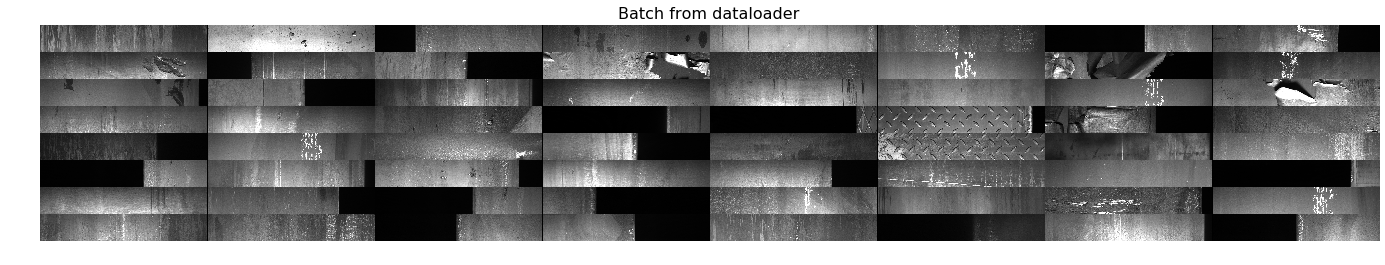

In [103]:
for i_batch, sample_batched in enumerate(train_loader):
    print(i_batch, sample_batched['image'].size(), sample_batched['label'])
    # observe 4th batch and stop.
    if i_batch == 0:
        plt.figure(figsize=(24, 24))
        show_image_batch(sample_batched)
        plt.axis('off')
        #plt.ioff()
        plt.show()
        break

In [104]:
#plt.imshow?

In [105]:
dataset.encoding

{'1': 0, '2': 1, '3': 2, '4': 3}

In [110]:
conv_neural_net = ConvNeuralNet()
#hwi_conv_neural_net.apply(init_weights)

In [107]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [108]:
print(device)

cuda:0


In [112]:
conv_neural_net.to(device)

ConvNeuralNet(
  (conv1): Conv2d(3, 32, kernel_size=(9, 9), stride=(2, 2), padding=(4, 4))
  (conv2): Conv2d(32, 64, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
  (fc1): Linear(in_features=524288, out_features=1024, bias=True)
  (fc2): Linear(in_features=1024, out_features=32, bias=True)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (sigmoid): Sigmoid()
  (dropout): Dropout(p=0.5)
)

In [ ]:
#linear_model = nn.Linear(IMAGE_W * IMAGE_H, 1)
#linear_model = nn.Linear(2048, 64)
#linear_model = nn.Linear(64, 2048)
'''
linear_model = nn.Sequential(
    nn.Linear(64, 2048),
    nn.Linear(BATCH_SIZE, 1),
    nn.Sigmoid()
)
'''

'''
linear_model = nn.Sequential(
    nn.Linear(2048, 64),
    nn.Linear(64, 1),
    nn.Sigmoid()
)
'''

In [116]:
class LogitsticRegression(nn.Module):
    
    def __init__(self, in_features_size, out_features_size):
        super(LogitsticRegression, self).__init__()
        self.fc = nn.Linear(in_features=in_features_size, out_features=out_features_size, bias=True)

    
    def forward(self, x):
        return self.fc(x)

In [117]:
class FullConnectedNeuralNet(nn.Module):
    
    def __init__(self, in_features_size, first_hl_features_size, second_hl_features_size, out_features_size):
        super(FullConnectedNeuralNet, self).__init__()
        #self.fc = nn.Linear(in_features=in_features_size, out_features=out_features_size, bias=True)
        self.fc0 = nn.Linear(in_features=in_features_size, out_features=first_hl_features_size, bias=True)
        self.fc1 = nn.Linear(in_features=first_hl_features_size, out_features=second_hl_features_size, bias=True)
        self.fc2 = nn.Linear(in_features=second_hl_features_size, out_features=int(second_hl_features_size / 2), bias=True)
        #self.fc2 = nn.Linear(in_features=first_hl_features_size, out_features=out_features_size, bias=True)
        self.fc3 = nn.Linear(in_features=int(second_hl_features_size / 2), out_features=int(second_hl_features_size / 4), bias=True)
        self.fc4 = nn.Linear(in_features=int(second_hl_features_size / 4), out_features=out_features_size, bias=True)
        self.sigmoid= nn.Sigmoid()
    
    def forward(self, x):
        print("forward, x.size(): ", x.size())
        #print("forward, type(x): ", type(x))
        x = x.view(-1, IMAGE_W * IMAGE_H)
        print("forward, x.size() after view: ", x.size())
        #x= self.fc(x)
        x = self.fc0(x)
        x = self.fc1(x)
        #print("forward after fc1, x.size(): ", x.size())
        x = self.fc2(x)
        print("forward after fc2, x.size(): ", x.size())
        x = self.fc3(x)
        print("forward after fc3, x.size(): ", x.size())
        x = self.fc4(x)
        print("forward after fc4, x.size(): ", x.size())
        x = self.sigmoid(x)
        print("forward after sigmoid, x.size(): ", x.size())
        return x

In [114]:
class SimpleConvNeuralNet(nn.Module):
    
    def __init__(self, in_features_size, out_conv1_features_size, kernel_size, stride,
                 #first_hl_features_size,
                 #second_hl_features_size,
                 #out_features_size
                ):
        super(SimpleConvNeuralNet, self).__init__()
        self.conv0 = nn.Conv2d(
            in_channels=in_features_size,
            out_channels=out_conv1_features_size,
            kernel_size=kernel_size,
            stride=stride,
            padding=0
        )
        ##self.fc = nn.Linear(in_features=in_features_size, out_features=out_features_size, bias=True)
        #self.fc0 = nn.Linear(in_features=1600, out_features=800, bias=True)
        self.fc0 = nn.Linear(in_features=15625, out_features=3125, bias=True)
        #self.fc0 = nn.Linear(in_features=800, out_features=400, bias=True)
        #self.fc0 = nn.Linear(in_features=in_features_size, out_features=first_hl_features_size, bias=True)
        #self.fc1 = nn.Linear(in_features=800, out_features=400, bias=True)
        self.fc1 = nn.Linear(in_features=3125, out_features=625, bias=True)
        #self.fc2 = nn.Linear(in_features=400, out_features=200, bias=True)
        self.fc2 = nn.Linear(in_features=625, out_features=125, bias=True)
        self.fc3 = nn.Linear(in_features=125, out_features=25, bias=True)
        self.fc4 = nn.Linear(in_features=25, out_features=1, bias=True)
        #self.fc1 = nn.Linear(in_features=first_hl_features_size, out_features=second_hl_features_size, bias=True)
        #self.fc2 = nn.Linear(in_features=second_hl_features_size, out_features=int(second_hl_features_size / 2), bias=True)
        ##self.fc2 = nn.Linear(in_features=first_hl_features_size, out_features=out_features_size, bias=True)
        #self.fc3 = nn.Linear(in_features=int(second_hl_features_size / 2), out_features=int(second_hl_features_size / 4), bias=True)
        #self.fc4 = nn.Linear(in_features=int(second_hl_features_size / 4), out_features=out_features_size, bias=True)
        self.sigmoid= nn.Sigmoid()
    
    def forward(self, x):
        
        #print("forward, x.size(): ", x.size())
        #print("forward, type(x): ", type(x))
        x = self.conv0(x)
        #print("forward, x.size() self.conv0: ", x.size())
        
        x = x.view(-1, x.size()[2] * x.size()[3])
        #print("forward, x.size() after view: ", x.size())
        #x= self.fc(x)
        x = self.fc0(x)
        #print("forward after fc, x.size(): ", x.size())
        x = self.fc1(x)
        #print("forward after fc1, x.size(): ", x.size())
        x = self.fc2(x)
        #print("forward after fc2, x.size(): ", x.size())
        x = self.fc3(x)
        #print("forward after fc3, x.size(): ", x.size())
        #x = self.fc3(x)
        x = self.fc4(x)
        #print("forward after fc4, x.size(): ", x.size())
        x = self.sigmoid(x)
        #print("forward after sigmoid, x.size(): ", x.size())
        return x
#RuntimeError: Expected 4-dimensional input for 4-dimensional weight [8192, 16384, 3, 3], but got input of size [1, 128, 128] instead

In [ ]:
#linear_model.to(device)

In [115]:
#logistic_regression_model = LogitsticRegression(IMAGE_W * IMAGE_H, 1)
#logistic_regression_model = LogitsticRegression(IMAGE_W * IMAGE_H, 2 * IMAGE_W * IMAGE_H, 2 * IMAGE_W * IMAGE_H, 1)
#logistic_regression_model = LogitsticRegression(IMAGE_W * IMAGE_H, int(IMAGE_W * IMAGE_H / 2), int(IMAGE_W * IMAGE_H / 2), 1)
#logistic_regression_model = LogitsticRegression(BATCH_SIZE, IMAGE_W * IMAGE_H)
#logistic_regression_model = LogitsticRegression(IMAGE_W * IMAGE_H, BATCH_SIZE)
#logistic_regression_model = LogitsticRegression(64, 2048)
#full_connected_neural_net = FullConnectedNeuralNet(IMAGE_W * IMAGE_H, int(IMAGE_W * IMAGE_H / 2), int(IMAGE_W * IMAGE_H / 2), 1)
#simple_conv_neural_net = SimpleConvNeuralNet(1, int(IMAGE_W * IMAGE_H / 2))

#simple_conv_neural_net = SimpleConvNeuralNet(1, 64, kernel_size=11, stride=3)
#simple_conv_neural_net = SimpleConvNeuralNet(64, 1, kernel_size=11, stride=3)
simple_conv_neural_net = SimpleConvNeuralNet(1, 1, kernel_size=4, stride=1)

In [ ]:
#logistic_regression_model.to(device)
#full_connected_neural_net.to(device)

In [118]:
simple_conv_neural_net.to(device)
print(simple_conv_neural_net)

SimpleConvNeuralNet(
  (conv0): Conv2d(1, 1, kernel_size=(4, 4), stride=(1, 1))
  (fc0): Linear(in_features=15625, out_features=3125, bias=True)
  (fc1): Linear(in_features=3125, out_features=625, bias=True)
  (fc2): Linear(in_features=625, out_features=125, bias=True)
  (fc3): Linear(in_features=125, out_features=25, bias=True)
  (fc4): Linear(in_features=25, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)


In [ ]:
#batch = train_iter.next()

In [ ]:
#type(batch)

In [ ]:
#keys = tuple(batch.keys())
#print(keys[0])
#print(keys[1])
#print(len(keys))

In [ ]:
#image = batch['image']
#print(type(image))
#print(image.size())
#print(image)
#expected input[64, 1, 128, 128]

In [ ]:
#image0 = image[0]
#print(type(image0))
#print(image0.size())

In [ ]:
#image0.to(device)

In [ ]:
#m = nn.Conv2d(1, 16, kernel_size=8, stride=1)
#m = nn.Conv2d(64, 1, kernel_size=5, stride=1)
#print(m)

In [ ]:
#output = m(image)

In [ ]:
#print(output.size())

In [ ]:
#image.to(device)

In [ ]:
#output = simple_conv_neural_net(image)
#print(output.size())

In [ ]:
#criterion = nn.BCEWithLogitsLoss(reduction='sum')
#criterion = nn.BCEWithLogitsLoss()
#criterion = nn.BCELoss()
#optimizer = optim.Adam(hwi_conv_neural_net.parameters(), lr=0.001, betas=(0.9, 0.99))

In [119]:
num_of_epoch = 40

In [120]:
learning_rate = 0.001

In [ ]:
#criterion = nn.CrossEntropyLoss()
#optimizer = optim.SGD(resnet18.parameters(), lr=learning_rate, momentum=0.9)

In [121]:
criterion = nn.BCELoss()
#criterion = nn.BCEWithLogitsLoss()
#optimizer = optim.Adam(resnet18.parameters(), lr=0.001, betas=(0.9, 0.99))
#optimizer = optim.Adam(linear_model.parameters(), lr=0.001, betas=(0.9, 0.99))
#optimizer = optim.Adam(logistic_regression_model.parameters(), lr=0.001, betas=(0.9, 0.99))
optimizer = optim.Adam(simple_conv_neural_net.parameters(), lr=0.001, betas=(0.9, 0.99))
#optimizer = optim.Adam(full_connected_neural_net.parameters(), lr=0.001, betas=(0.9, 0.99))

In [122]:
train_rezult_metrics = train_model(
    num_of_epoch,
    #hwi_conv_neural_net,
    #resnet18,
    #linear_model,
    #logistic_regression_model,
    #full_connected_neural_net,
    simple_conv_neural_net,
    dataset_loaders,
    dataset_sizes,
    criterion,
    optimizer
)

RuntimeError: size mismatch, m1: [64 x 404041], m2: [15625 x 3125] at /opt/conda/conda-bld/pytorch_1525812548180/work/aten/src/THC/generic/THCTensorMathBlas.cu:249

In [ ]:
train_losses, validation_losses, train_accuracies, validation_accuracies = train_rezult_metrics

In [ ]:
plt.plot(np.arange(len(train_losses)), train_losses, label='train')
plt.plot(np.arange(len(validation_losses)), validation_losses, label='validation')
plt.legend()
plt.title("loss by epoch")
plt.show()

plt.plot(np.arange(len(train_accuracies)), train_accuracies, label='train')
plt.plot(np.arange(len(validation_accuracies)), validation_accuracies, label='validation')
plt.legend()
plt.title("accuracy by epoch")
plt.show()

In [ ]:
train_rezult_metrics

In [ ]:
#save_model(full_connected_neural_net, full=True, name='full_connected_neural_net_5_layers-2019-02-16')
save_model(simple_conv_neural_net, full=True, name='simple_conv_neural_net-2019-02-26')

In [ ]:
torch.cuda.empty_cache()

In [123]:
train_df.head()

,ImageId_ClassId,EncodedPixels,image_name,image_class
0,0002cc93b.jpg_1,29102 12 29346 24 29602 24 29858 24 30114 24 3...,0002cc93b.jpg,1
1,0002cc93b.jpg_2,NaN,0002cc93b.jpg,2
2,0002cc93b.jpg_3,NaN,0002cc93b.jpg,3
3,0002cc93b.jpg_4,NaN,0002cc93b.jpg,4
4,00031f466.jpg_1,NaN,00031f466.jpg,1


In [124]:
train_df['image_class'].value_counts()

1    12568
4    12568
2    12568
3    12568
Name: image_class, dtype: int64

In [125]:
train_df.shape

(50272, 4)

In [126]:
4 * 12568

50272

In [127]:
len_imgid_class_id = [len(item) for item in train_df['ImageId_ClassId']]

In [128]:
len_imgid_class_id[:6]

[15, 15, 15, 15, 15, 15]

In [129]:
all(item == 15 for item in len_imgid_class_id)

True

In [130]:
any(item != 15 for item in len_imgid_class_id)

False